# Plotting animated GIFs from time series imagery

**What does this notebook do?** 

This notebook demonstrates how to import a time series of DEA cloud-free Landsat imagery from multiple sensors (i.e. Landsat 5, 7 and 8) as an xarray dataset, and then plot the data as an animated time series GIF and a transitioning/fading GIF that compares two timesteps. Animations can be produced as either GIFs or MP4s for any area in Australia using a standard datacube query.

**Required inputs**

This example uses three external functions called `load_clearlandsat`, `animated_timeseries` and `animated_fade`. These functions are available in the Scripts folder of the [dea-notebooks Github repository](https://github.com/GeoscienceAustralia/dea-notebooks/tree/master/Scripts). Note that these functions have been developed by DEA users, not the DEA development team, and so are provided without warranty. If you find an error or bug in the functions, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated function back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

**Date:** May 2018

**Author:** Robbi Bishop-Taylor

In [5]:
# Import modules
import datacube 
import sys
import numpy as np
import pickle
from datacube.utils import geometry
from datacube.utils.geometry import CRS
import matplotlib.pyplot as plt

# Import external dea-notebooks functions using relative link to Scripts directory
sys.path.append('../Scripts')
import DEADataHandling
import DEAPlotting

# Set up datacube instance
dc = datacube.Datacube(app='Time series animation')

# Set up analysis data query using a buffer around a lat-long point
lat, lon, buffer = -22.473794, 113.813742, 9000
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),    
#          'time': ('1995-06-01', '2018-12-30'),
#          'time': ('2008-05-01', '2015-04-17'),  
         'crs': 'EPSG:3577'}


## Extract cloud-free clear Landsat observations from all sensors
Use the `load_clearlandsat` function to load Landsat observations and PQ data for multiple sensors (i.e. ls5, ls7, ls8), and return a single xarray dataset containing only observations that contain greater than a specified proportion of clear pixels. This uses `dask` to only load in the filtered observations, and results in a visually appealing time series of observations that are not affected by cloud!

In [ ]:
# Custom mask that includes only cloudy or cloud shadowed pixels with data for all bands
custom_mask = {'cloud_acca': 'no_cloud', 
               'cloud_fmask': 'no_cloud', 
               'cloud_shadow_acca': 'no_cloud_shadow',
               'cloud_shadow_fmask': 'no_cloud_shadow',
               'contiguous': True}

# Load in data
ds2 = DEADataHandling.load_clearlandsat(dc=dc, query=query, product='fc', 
                                        masked_prop=0.999, mask_dict=custom_mask, apply_mask=False) 

# Mask FC
ds2['PV'] = ds2.PV.where(ds2.UE < 18)
ds2['NPV'] = ds2.NPV.where(ds2.UE < 18)
ds2['BS'] = ds2.BS.where(ds2.UE < 18)

# Remove duplicates by taking first timestep
ds2 = ds2.groupby('time').first()

# Identify dodgy timesteps and timesteps in only one dataset
times_to_drop1 = ds2.PV.loc['1999-10-28':'2000-01-18'].time.values
times_to_drop2 = ds2.PV.loc['2000-12-17':'2000-12-19'].time.values
times_to_drop3 = ds2.PV.loc['2006-05-16':'2006-05-18'].time.values
times_to_drop4 = ds2.PV.loc['2006-10-07':'2006-11-26'].time.values
times_to_drop5 = ds2.PV.loc['2018-02-01':'2018-02-03'].time.values

# Remove timesteps
times_to_drop=np.concatenate([times_to_drop1, times_to_drop2, 
                              times_to_drop3, times_to_drop4, times_to_drop5])
ds2 = ds2.drop(times_to_drop, dim="time")

# Export
pickle.dump(ds2, open("ds2.p", "wb"), protocol=-1)


In [ ]:
# Custom mask that includes only cloudy or cloud shadowed pixels with data for all bands
custom_mask = {'cloud_acca': 'no_cloud', 
               'cloud_fmask': 'no_cloud', 
               'cloud_shadow_acca': 'no_cloud_shadow',
               'cloud_shadow_fmask': 'no_cloud_shadow',
               'contiguous': True}

# Load in data
ds1 = DEADataHandling.load_clearlandsat(dc=dc, query=query, product='nbart', 
                                        bands_of_interest=['red', 'green', 'blue'], 
                                        masked_prop=0.999, mask_dict=custom_mask, apply_mask=False)  

# # Remove duplicates by taking first timestep
ds1 = ds1.groupby('time').first()

# Identify dodgy timesteps and timesteps in only one dataset
times_to_drop1 = ds1.red.loc['1999-10-28':'2000-01-18'].time.values
times_to_drop2 = ds1.red.loc['2000-12-17':'2000-12-19'].time.values
times_to_drop3 = ds1.red.loc['2006-05-16':'2006-05-18'].time.values
times_to_drop4 = ds1.red.loc['2006-10-07':'2006-11-26'].time.values
times_to_drop5 = ds1.red.loc['2018-02-01':'2018-02-03'].time.values
# times_to_drop5 = np.setxor1d(ds1.time.values, ds2.time.values)

# Remove timesteps
times_to_drop=np.concatenate([times_to_drop1, times_to_drop2, 
                              times_to_drop3, times_to_drop4, times_to_drop5])

# ds1 = ds1.drop(times_to_drop, dim="time")
ds1 = ds1.drop(times_to_drop, dim="time")

# Export
pickle.dump(ds1, open("ds1.p", "wb"), protocol=-1)


##  Import data back in

In [3]:
# Import back in
ds1 = pickle.load(open("ds1.p", "rb"))
ds2 = pickle.load(open("ds2.p", "rb"))
print(ds1)
print(ds2)


<xarray.Dataset>
Dimensions:    (time: 332, x: 721, y: 720)
Coordinates:
  * y          (y) float64 -2.543e+06 -2.543e+06 -2.543e+06 -2.543e+06 ...
  * x          (x) float64 -1.858e+06 -1.858e+06 -1.858e+06 -1.858e+06 ...
  * time       (time) datetime64[ns] 1987-05-29T01:45:22.500000 ...
Data variables:
    BS         (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    PV         (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    NPV        (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    UE         (time, y, x) float64 80.0 83.0 71.0 74.0 79.0 66.0 85.0 74.0 ...
    data_perc  (time) float64 0.9999 0.9999 0.9999 1.0 0.9999 1.0 0.9999 1.0 ...
<xarray.Dataset>
Dimensions:    (time: 332, x: 721, y: 720)
Coordinates:
  * y          (y) float64 -2.543e+06 -2.543e+06 -2.543e+06 -2.543e+06 ...
  * x          (x) float64 -1.858e+06 -1.858e+06 -1.858e+06 -1.858e+06 ...
  * time       (time) datetime64[ns] 1987-05-29T01:45:22.500000 ...
D

In [ ]:
# # Animate datasets    
# DEAPlotting.animated_doubletimeseries(ds1=ds1, ds2=ds2, 
#                           output_path='/home/561/rt1527/Transfer/animation_rangelands.mp4',
#                           width_pixels=800, interval=100,
#                           bands1=['red', 'green', 'blue'], bands2=['PV'], 
#                           reflect_stand1=2800, reflect_stand2=1500, 
#                           title1="Satellite imagery", title2="Growing vegetation",
#                           onebandplot_kwargs2={'cmap':'YlGn', 'vmin':0, 'vmax':50},
#                           annotation_kwargs1={'fontsize':18}, annotation_kwargs2={'fontsize':18})

# # Animate datasets    
# DEAPlotting.animated_doubletimeseries(ds1=ds2, ds2=ds2, 
#                           output_path='/home/561/rt1527/Transfer/animation_rangelands4.mp4',
#                           width_pixels=800, interval=100,
#                           bands1=['PV'], bands2=['NPV'], 
#                           reflect_stand1=2800, reflect_stand2=1500, 
#                           title1="Growing vegetation", title2="Dead/dried vegetation",
#                           onebandplot_kwargs1={'cmap':'YlGn', 'vmin':0, 'vmax':50},
#                           onebandplot_kwargs2={'cmap':'YlOrBr', 'vmin':0, 'vmax':70},
#                           annotation_kwargs1={'fontsize':18}, annotation_kwargs2={'fontsize':18})

# # Animate datasets    
# DEAPlotting.animated_doubletimeseries(ds1=ds2, ds2=ds2, 
#                           output_path='/home/561/rt1527/Transfer/animation_rangelands2.mp4',
#                           width_pixels=800, interval=100,
#                           bands1=['NPV'], bands2=['BS'], 
#                           reflect_stand1=2800, reflect_stand2=1500, 
#                           title1="Dead/dried vegetation", title2="Bare earth",
#                           onebandplot_kwargs1={'cmap':'YlOrBr', 'vmin':0, 'vmax':70},
#                           onebandplot_kwargs2={'cmap':'YlOrBr', 'vmin':0, 'vmax':70},
#                           annotation_kwargs1={'fontsize':18}, annotation_kwargs2={'fontsize':18})

In [ ]:
# Polygon drill 
ds2.isel(x=slice(350, 450), y=slice(350, 450)).mean(dim=["y", "x"], skipna=True).BS.plot()
ds2.isel(x=slice(350, 450), y=slice(350, 450)).mean(dim=["y", "x"], skipna=True).PV.plot()
ds2.isel(x=slice(350, 450), y=slice(350, 450)).mean(dim=["y", "x"], skipna=True).NPV.plot()
# ds2.isel(x=slice(350, 450), y=slice(350, 450)).mean(dim=["y", "x"], skipna=True).PV.values

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import datetime 
import matplotlib.lines as mlines

# ds3 = ds2.isel(x=slice(350, 450), y=slice(350, 450)).mean(dim=["y", "x"], skipna=True)[["BS", "PV", "NPV"]]
ds3 = ds2.median(dim=["y", "x"], skipna=True)[["BS", "PV", "NPV"]]
array_data = ds3.to_array().values.T

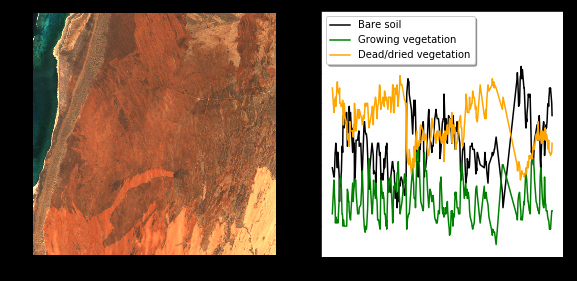

In [17]:
ds1 = ds1
bands1=['red', 'green', 'blue']
reflect_stand1=2500

# Define function to convert xarray dataset to list of three band numpy arrays
def _ds_to_arrraylist(ds, bands, reflect_stand):   

    array_list = []
    for i, timestep in enumerate(ds.time):

        # Select single timestep from the data array
        ds_i = ds.isel(time = i)

        # Create new three band array
        y, x = ds_i[bands[0]].shape

        if len(bands) == 1:    

            # Create new three band array
            img_toshow = ds_i[bands[0]].values

        else:

            rawimg = np.zeros((y, x, 3), dtype=np.float32)

            # Add xarray bands into three dimensional numpy array
            for band, colour in enumerate(bands):

                rawimg[:, :, band] = ds_i[colour].values

            # Stretch contrast using defined reflectance standardisation; defaults to 5000
            img_toshow = (rawimg / reflect_stand).clip(0, 1)

        array_list.append(img_toshow)

    return(array_list)


# Prep plot array
x = ds3.to_array().time.values 
y1 = array_data[:,0]
y2 = array_data[:,1]
y3 = array_data[:,2]
imagelist1 = _ds_to_arrraylist(ds1, bands=bands1, reflect_stand=reflect_stand1)


# Set up figure
fig, (ax1, ax2) = plt.subplots(ncols=2) 
fig.patch.set_facecolor('black')
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
fig.set_size_inches(8.1, 4, forward=True)
ax1.axis('off')
ax2.set_ylabel('Percent cover (%)')

# Initialise right panel
line1, = ax2.plot(x, y1, color='black', label='Bare soil')
line2, = ax2.plot(x, y2, color='green', label='Growing vegetation')
line3, = ax2.plot(x, y3, color='orange', label='Dead/dried vegetation')

# Legend to right panel
ax2.legend(loc='upper left', bbox_to_anchor=(0, 1),
          ncol=1, fancybox=True, shadow=True)

# Initialise left panel
im1 = ax1.imshow(imagelist1[0])

def update(num):
    
    # Update right panel
    line1.set_data(x[:num], y1[:num])
    line2.set_data(x[:num], y2[:num])
    line3.set_data(x[:num], y3[:num])
    line1.axes.axis(ymin=0, ymax=80)
    
    # Update left panel
    im1.set_array(imagelist1[num])
    
    return [im1, line1, line2, line3]

fig.tight_layout()

ani = animation.FuncAnimation(fig, update, len(x), interval=100, blit=True)  #len(x)
# ani.save('/home/561/rt1527/Transfer/test.gif', writer='imagemagick', dpi=80)
ani.save('/home/561/rt1527/Transfer/test.mp4')

In [8]:
ds2

<xarray.Dataset>
Dimensions:    (time: 332, x: 721, y: 720)
Coordinates:
  * y          (y) float64 -2.543e+06 -2.543e+06 -2.543e+06 -2.543e+06 ...
  * x          (x) float64 -1.858e+06 -1.858e+06 -1.858e+06 -1.858e+06 ...
  * time       (time) datetime64[ns] 1987-05-29T01:45:22.500000 ...
Data variables:
    BS         (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    PV         (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    NPV        (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    UE         (time, y, x) float64 80.0 83.0 71.0 74.0 79.0 66.0 85.0 74.0 ...
    data_perc  (time) float64 0.9999 0.9999 0.9999 1.0 0.9999 1.0 0.9999 1.0 ...

In [ ]:
lat, lon = -35.7088156139, 150.121438256

query = {'x': (lon - 0.1, lon + 0.1),
         'y': (lat + 0.1, lat - 0.1),    
         'time': ('2015-01-01', '2016-12-30'),
         'output_crs': 'EPSG:4326',
         'resolution': (0.000278, 0.000278)}

dc.load(product="ls8_level1_scene", **query)

In [ ]:
def _ds_to_arrraylist(ds, bands, reflect_stand):   

    array_list = []
    for i, timestep in enumerate(ds.time):

        # Select single timestep from the data array
        ds_i = ds.isel(time = i)

        # Create new three band array
        y, x = ds_i[bands[0]].shape

        if len(bands) == 1:    

            # Create new three band array
            img_toshow = ds_i[bands[0]].values

        else:

            rawimg = np.zeros((y, x, 3), dtype=np.float32)

            # Add xarray bands into three dimensional numpy array
            for band, colour in enumerate(bands):

                rawimg[:, :, band] = ds_i[colour].values

            # Stretch contrast using defined reflectance standardisation; defaults to 5000
            img_toshow = (rawimg / reflect_stand).clip(0, 1)

        array_list.append(img_toshow)

    return(array_list)




In [ ]:
bands=["red"]

ds = ds1[["red"]]





# Select single timestep from the data array
ds_i = ds.isel(time = 0)

# Create new three band array
img_toshow = ds_i[bands[0]].values
img_toshow

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

text = plt.text(0.5, 0.5, 'Hello path effects world!',
                path_effects=[path_effects.withSimplePatchShadow()])

plt.plot([0, 3, 2, 5], linewidth=5, color='blue',
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
plt.show()